In [7]:
#Importing Libraries required for Analysis 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Defining file path to load data 
file_path = r"D:\\Churn_Analysis\\Prediction_data.xlsx"
sheet_name = 'vw_ChurnData'

#Reading the data from the sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name)
print(data.head())

  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   11098-MAD  Female   30     Yes  Madhya Pradesh                    0   
1   11114-PUN    Male   51      No          Punjab                    5   
2   11167-WES  Female   43     Yes     West Bengal                    3   
3   11179-MAH    Male   35      No     Maharashtra                   10   
4   11180-TAM    Male   75     Yes      Tamil Nadu                   12   

   Tenure_in_Months Value_Deal Phone_Service Internet_Type  ...  \
0                31     Deal 1           Yes   Fiber Optic  ...   
1                 9     Deal 5           Yes           DSL  ...   
2                28     Deal 1           Yes   Fiber Optic  ...   
3                12        NaN           Yes           DSL  ...   
4                27     Deal 2           Yes           DSL  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      95.099998   6683.399902          0.00   
1  Bank Withdraw

In [9]:
# Data Processing 

# Drop columns that won't be used for prediction 
data = data.drop(['Customer_ID', 'Churn_Category', 'Churn_Reason'], axis=1, errors='ignore')

# Listing of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 
    'Internet_Type', 'Online_Security', 'Online_Backup', 
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 
    'Streaming_Movies', 'Streaming_Music', 'Unlimited_Data', 
    'contract', 'Paperless_Billing', 'Payment_Method'
]

# Handle NaNs in categorical columns FIRST
for column in columns_to_encode:
    data[column] = data[column].fillna(data[column].mode()[0])

# Encoding categorical variables except the target variable 
label_encoders = {}
for column in columns_to_encode:
    if column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# Fix target variable - Handle NaNs and unmapped values
data['Customer_Status'] = data['Customer_Status'].fillna('Stayed')
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})
data = data.dropna(subset=['Customer_Status'])  # Drop any remaining bad rows

# Splitting data into features and target 
x = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
# Training Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Confusion Matrix:
[[776  71]
 [126 229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       847
           1       0.76      0.65      0.70       355

    accuracy                           0.84      1202
   macro avg       0.81      0.78      0.79      1202
weighted avg       0.83      0.84      0.83      1202



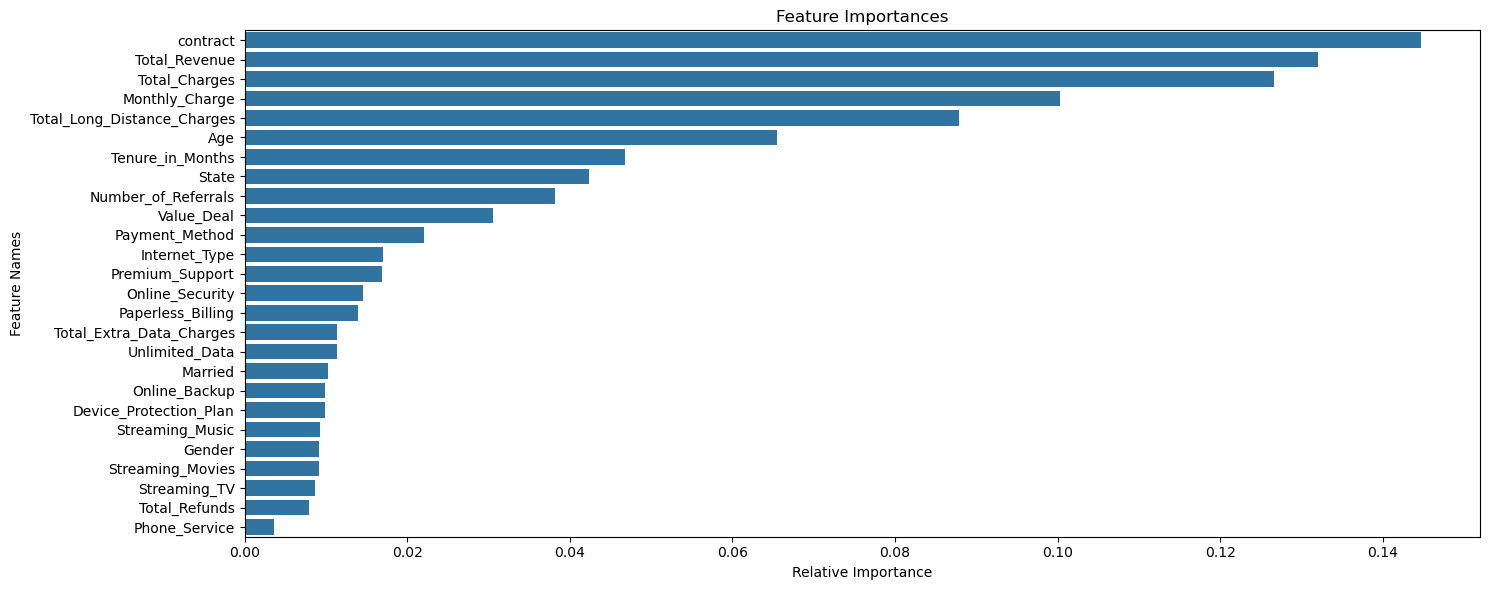

In [11]:
# Make predictions
y_pred = rf_model.predict(x_test)  

# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")  
print(classification_report(y_test, y_pred))  

# Feature Selection using Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  

# Plotting the feature importances
plt.figure(figsize=(15,6))
sns.barplot(x=importances[indices], y=x.columns[indices])  
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.tight_layout()  
plt.show()


In [15]:
# Predict on New Data (KEEP ORIGINAL CATEGORIES)

# Define the path to the Joiner Data Excel file 
file_path = r"D:\Churn_Analysis\Prediction_data.xlsx"  
sheet_name = 'vw_JoinedData'

# Read the data from the specified sheet into a pandas DataFrame 
new_data = pd.read_excel(file_path, sheet_name=sheet_name)
print(new_data.head())

# KEEP ORIGINAL DATA INTACT
original_data = new_data.copy()  # This has real categories
customer_ids = new_data['Customer_ID'].copy()

# CREATE SEPARATE COPY for model prediction only
model_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], 
                          axis=1, errors='ignore').copy()

# Encode ONLY model_data (not original)
for column in columns_to_encode:
    if column in label_encoders and column in model_data.columns:
        try:
            model_data[column] = label_encoders[column].transform(model_data[column])
        except ValueError as e:
            print(f"Warning: Unseen category in {column}. Using most frequent...")
            model_data[column] = model_data[column].fillna(model_data[column].mode()[0])
            model_data[column] = label_encoders[column].transform(model_data[column])

# Fill numeric NaNs in model_data only
numeric_cols = model_data.select_dtypes(include=[np.number]).columns
model_data[numeric_cols] = model_data[numeric_cols].fillna(model_data[numeric_cols].median())

# Making Predictions 
new_predictions = rf_model.predict(model_data)

# MERGE predictions back to ORIGINAL data (with real categories)
original_data['Customer_Status_Predicted'] = new_predictions
original_data['Churn_Risk'] = original_data['Customer_Status_Predicted'].map({0: 'Stayed', 1: 'Churned'})

# Filter to include only predicted "Churned" customers (1)
churned_customers = original_data[original_data['Customer_Status_Predicted'] == 1].copy()

# Save as EXCEL (business-ready with original categories)
churned_customers.to_excel(r"D:\Churn_Analysis\churned_customers_predicted.xlsx", index=False)
print(f"Saved {len(churned_customers)} predicted churners to EXCEL!")
print("\nFirst 5 predicted churners (with original categories):")
print(churned_customers[['Customer_ID', 'Gender', 'contract', 'Churn_Risk']].head())


  Customer_ID  Gender  Age Married        State  Number_of_Referrals  \
0   11751-TAM  Female   18      No   Tamil Nadu                    5   
1   12056-WES    Male   27      No  West Bengal                    2   
2   12136-RAJ  Female   25     Yes    Rajasthan                    2   
3   12257-ASS  Female   39      No        Assam                    9   
4   12340-DEL  Female   51     Yes        Delhi                    0   

   Tenure_in_Months Value_Deal Phone_Service Internet_Type  ...  \
0                 7     Deal 5            No           DSL  ...   
1                20        NaN           Yes   Fiber Optic  ...   
2                35        NaN           Yes           NaN  ...   
3                 1        NaN           Yes           NaN  ...   
4                10        NaN           Yes         Cable  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      24.299999     38.450001           0.0   
1  Bank Withdrawal      90.400002 